<div style="border-radius: 5px; padding: 1rem; margin-bottom: 1rem">
<img src="https://www.prototypesforhumanity.com/wp-content/uploads/2022/11/LOGO_UTEC_.png" alt="Banner" width="150" />   
 </div>

# Laboratorio 5.2: Similitud de Coseno e Indice Invertido

> **Daniel Ignacio Casquino Paz**  
> **Jesús Valentín Niño Castañeda**

PD: El código completo para pruebas de ejecución se encuentra al final del documento.

## Requisitos Previos
### Dependencias:

In [ ]:
import json
import time
import pandas as pd
import math
import psycopg2
import warnings
import json
import nltk
import re
import bisect
import numpy as np

#nltk.download("punkt")
#nltk.download("punkt_tab")

stemmer = nltk.stem.SnowballStemmer("spanish")
lemmatizer = nltk.stem.WordNetLemmatizer()

# Omitir advertencias de pandas sobre SQLAlchemy
warnings.filterwarnings(
    "ignore",
    message="pandas only supports SQLAlchemy connectable",
    category=UserWarning,
)

### Funciones del laboratorio anterior:

In [ ]:
def connect_db():
    conn = psycopg2.connect(
        dbname="Lab5.1",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5432",
    )
    return conn

def fetch_document(id: int):
    conn = connect_db()
    query = f"SELECT * FROM noticias WHERE noticias.id = {id};"
    df = pd.read_sql(query, conn)
    df["bag_of_words"] = df["bag_of_words"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    conn.close()
    return df

def fetch_data():
    conn = connect_db()
    query = "SELECT id, contenido, bag_of_words FROM noticias;"
    df = pd.read_sql(query, conn)
    df["bag_of_words"] = df["bag_of_words"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    conn.close()
    return df

def fetch_stopwords():
    conn = connect_db()
    query = "SELECT word FROM stopwords;"
    df = pd.read_sql(query, conn)
    conn.close()
    stopword_list = df["word"].tolist()
    return stopword_list

stopwords = fetch_stopwords()
noticias_df = fetch_data()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñü\s]", "", text)
    tokens = nltk.word_tokenize(text, "spanish")
    filtered = [token for token in tokens if token not in stopwords]
    stem = [stemmer.stem(w) for w in filtered]
    return stem

def compute_bow(text):
    processed_text = preprocess(text)
    bow = dict()
    for word in processed_text:
        if word in bow:
            bow[word] += 1
        else:
            bow[word] = 1
    return bow

def update_bow_in_db(dataframe):
    conn = connect_db()
    cursor = conn.cursor()
    for _, row in dataframe.iterrows():
        bow = compute_bow(row["contenido"])
        query = "UPDATE noticias SET bag_of_words = %s WHERE id = %s;"
        cursor.execute(query, (json.dumps(bow), row["id"]))
    conn.commit()
    cursor.close()
    conn.close()


## 1. Bag of Words y Similitud de Coseno

Primero se procesa la query para convertila a tokens y lematizarla, luego se convierte a una query booleana con ORs y se envía a la función correspondiente, desarrollada en el laboratorioa anterior, que retorna un dataframe con todas los documentos que contienen las palabras de la query.

La función bows_to_vectors obtiene el vobulario entero y calcula el idf para cada palabra, luego a partir de los bags of words de cada documentos recibidos genera su vector de frecuencia ponderada y lo utiliza para calcular un vector de tf_idfs que luego se normaliza convirtiendolo a vectorunitario. Estos vectores se agregan al dataframe como una nueva columna llamada "tf_idf".

La función calculate_similarity recibe la query, el dataframe actualizado con la columna "tf_idf", y el vocabulario e idfs calculados en la función anterior. Calcula el vector de tf_idfs normalizado siguiente el mismo procedimiento de antes y luego aplica el producto punto el vector "tf_idf" de cada documento para calcular su simulitud coseno y lo agrega como una nueva columna al dataframe. Finalmente lo ordena de manera no ascendente por su valor de "similitud".

Luego de haber obtenido los documentos ordenados por su relevancia, la función serch devuelve los "k" más relevantes.

Ejemplo de ejecución:
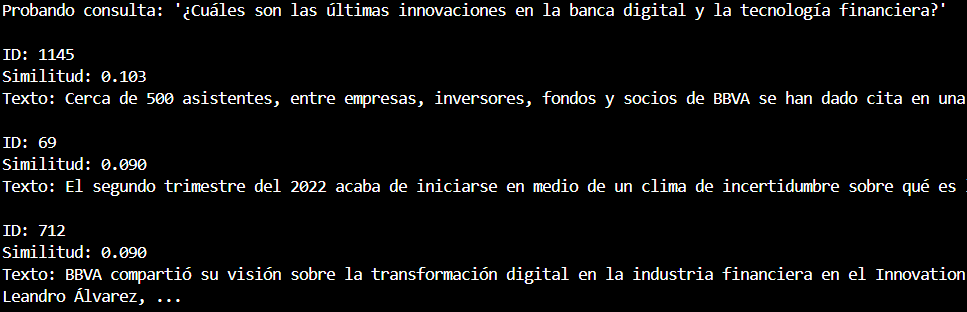

In [ ]:
def bows_to_vectors(df):
    vocab = set()
    df_counts = dict()
    for bow in df["bag_of_words"]:
        for word in bow:
            vocab.add(word)
            if word in df_counts:
                df_counts[word] += 1
            else:
                df_counts[word] = 1
    
    vocab = sorted(vocab)
    N = len(df)
    idf = {word: math.log(N / df_counts[word]) for word in vocab}

    tf = []
    for bow in df["bag_of_words"]:
        vector = [1 + math.log(bow.get(word, 0)) if bow.get(word, 0) > 0 else 0 for word in vocab]
        tf.append(vector)
    
    tf_idf = []
    for tf_vector in tf:
        tf_idf_vector = [t * idf[word] for word, t in zip(vocab, tf_vector)]
        tf_idf.append(tf_idf_vector)
    
    normalized_tf_idf = []
    for val in tf_idf:
        mag = math.sqrt(sum([t**2 for t in val]))
        if mag > 0:
            val = [t / mag for t in val]
        normalized_tf_idf.append(val)

    df["tf_idf"] = normalized_tf_idf

    return df, vocab, idf

def calculate_similarity(query, df, vocab, idf):
    query_bow = compute_bow(query)
    query_tf = [1 + math.log(query_bow.get(word, 0)) if query_bow.get(word, 0) > 0 else 0 for word in vocab]
    query_tf_idf = [t * idf[word] for word, t in zip(vocab, query_tf)]
    query_mag = math.sqrt(sum([t**2 for t in query_tf_idf]))
    query_normalized = [t / query_mag for t in query_tf_idf]
    df["similarity"] = df["tf_idf"].apply(lambda x: sum([a * b for a, b in zip(x, query_normalized)]))
    df = df.sort_values(by="similarity", ascending=False)
    return df

def search(query, top_k=5, table="noticias"):
    processed_query = preprocess(query)
    # build query from stemmed
    final_query = ""
    for i, s in enumerate(processed_query):
        if i < len(processed_query) - 1:
            final_query += f"{s} OR "
        else:
            final_query += s
    df = apply_boolean_query(final_query, table)
    df, vocab, idf = bows_to_vectors(df)
    df = calculate_similarity(query, df, vocab, idf)
    return df.head(top_k)

## 2. Construcción del Índice Invertido
A continuación se muestra la definición del índice invertido y sus métodos.

In [ ]:
class InvertedIndex:
    def __init__(self):
        self.index = {}  # key should be a word, value should be a list of doc_id, word freq in doc tuples in descending order
        self.idf = {}
        self.length = {}

    def showDocument(self, id: int):
        df = fetch_document(id)
        return df["contenido"]
    
    def showDocuments(self, ids: list):
        docs = []
        for tuple in ids:
            id = tuple[0]
            df = fetch_document(id)
            docs.append(df["contenido"])
        return docs

    def insert_index_sorted(self, word, id, freq):
        if word not in self.index:
            self.index[word] = []
        bisect.insort(self.index[word], (id, freq))

    def update_idf(self, word):
        if word not in self.idf:
            self.idf[word] = 0
        self.idf[word] += 1

    def update_length(self, id, freq):
        if id not in self.length:
            self.length[id] = 0
        self.length[id] = math.sqrt(self.length[id] ** 2 + freq**2)

    def build_from_db(self):
        # Leer desde PostgreSQL todos los bag of words
        # Construir el índice invertido, el idf y la norma (longitud) de cada documento

        """
        store id of doc instead of literally doc1
        indice  = {
            "word1": [("doc1", tf1), ("doc2", tf2), ("doc3", tf3)],
            "word2": [("doc2", tf2), ("doc4", tf4)],
            "word3": [("doc3", tf3), ("doc5", tf5)],
        }
        idf  = {
            "word1": 3,
            "word2": 2,
            "word3": 2,
        }
        length = {
            "doc1": 15.5236,
            "doc2": 10.5236,
            "doc3": 5.5236,
        }
        """
        df = fetch_data()
        # df has id, contenido, bag_of_words
        for _, row in df.iterrows():
            bow = row["bag_of_words"]
            for word, freq in bow.items():
                self.insert_index_sorted(word, row["id"], freq)
                self.update_idf(word)
                self.update_length(row["id"], freq)

    def L(self, word) -> list[tuple[str, int]]:
        word = stemmer.stem(word)
        return self.index.get(word, [])

    def cosine_search(self, query, top_k=5):
        # No es necesario usar vectores numericos del tamaño del vocabulario
        # Guiarse del algoritmo visto en clase
        # Se debe calcular el tf-idf de la query y de cada documento

        score = {}
        vectors = {}  # id, list of frequencies
        query_bow = compute_bow(query)  # get stemmed tokens
        tokens = list(query_bow.keys())

        query_vec = []

        N = len(self.length)  # n total documents

        for col, tok in enumerate(tokens):
            # progressive query vector building
            tf = query_bow[tok]  # tf is tok's raw frequency in query
            tf = 1 + np.log(tf) if tf > 0 else 0
            df = self.idf[tok]  # n of documents that contain tok
            idf = np.log(N / df)
            query_vec.append(tf * idf)

            matching_docs = self.L(tok)  # returns list of docs that contain word
            for id, raw_freq in matching_docs:
                # init vector if not present
                if id not in vectors:
                    vectors[id] = [0] * len(tokens)
                tf = 1 + np.log(raw_freq) if raw_freq > 0 else 0
                vectors[id][col] = tf * idf  # calc tf-idf here

        query_mag = np.linalg.norm(query_vec)

        # now calculate mag of all documents and also cos(angle)
        for id, vec in vectors.items():
            curr_mag = np.linalg.norm(vec)
            score[id] = np.dot(query_vec, vec) / (query_mag * curr_mag)

        # Ordenar el score resultante de forma descendente
        result = sorted(score.items(), key=lambda tup: tup[1], reverse=True)
        # retornamos los k documentos mas relevantes (de mayor similitud a la query)
        return result[:top_k]

## 3. Consultas Booleanas usando el índices invertido
Se aplican los algoritmos expuestos en clase.

Ejemplo de ejecución:
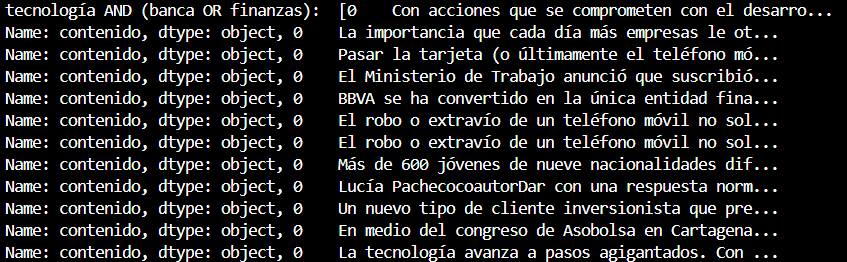

In [1]:
def AND(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            result.append(list1[i])
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            i += 1
        else:
            j += 1
    return result

def OR(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            result.append(list1[i])
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            result.append(list1[i])
            i += 1
        else:
            result.append(list2[j])
            j += 1
    return result

def AND_NOT(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            result.append(list1[i])
            i += 1
        else:
            j += 1
    while (i < len(list1)):
        result.append(list1[i])
        i += 1
    return result

def test3():
    idx = InvertedIndex()
    idx.build_from_db()
    # Prueba 1
    result = AND(idx.L("sostenibilidad"), AND(idx.L("ambiente"), idx.L("renovables")))
    print("sostenibilidad AND ambiente AND renovable: ", idx.showDocuments(result))

    # Prueba 2
    result = AND(idx.L("tecnología"), OR(idx.L("banca"), idx.L("finanzas")))
    print("tecnología AND (banca OR finanzas): ", idx.showDocuments(result))

    # Prueba 3
    result = AND_NOT(idx.L("economía"), idx.L("inflación"))
    print("economía AND-NOT inflación: " , idx.showDocuments(result))

## 4. Similitud de cosena usando el índices invertido
Se modificó ligeramente las queries de prueba para incluir un "top_k" y se utilizó el algoritmo presenta en la diapositivas de la clase relevante.

Ejemplo de ejecución:
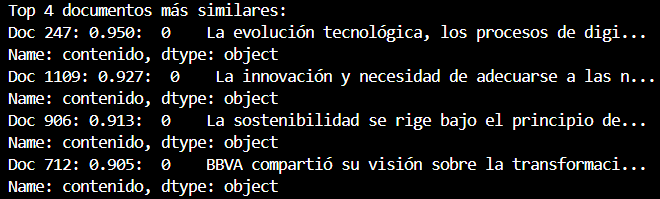

In [ ]:
def cosine_search(self, query, top_k=5):
        # No es necesario usar vectores numericos del tamaño del vocabulario
        # Guiarse del algoritmo visto en clase
        # Se debe calcular el tf-idf de la query y de cada documento

        score = {}
        vectors = {}  # id, list of frequencies
        query_bow = compute_bow(query)  # get stemmed tokens
        tokens = list(query_bow.keys())

        query_vec = []

        N = len(self.length)  # n total documents

        for col, tok in enumerate(tokens):
            # progressive query vector building
            tf = query_bow[tok]  # tf is tok's raw frequency in query
            tf = 1 + np.log(tf) if tf > 0 else 0
            df = self.idf[tok]  # n of documents that contain tok
            idf = np.log(N / df)
            query_vec.append(tf * idf)

            matching_docs = self.L(tok)  # returns list of docs that contain word
            for id, raw_freq in matching_docs:
                # init vector if not present
                if id not in vectors:
                    vectors[id] = [0] * len(tokens)
                tf = 1 + np.log(raw_freq) if raw_freq > 0 else 0
                vectors[id][col] = tf * idf  # calc tf-idf here

        query_mag = np.linalg.norm(query_vec)

        # now calculate mag of all documents and also cos(angle)
        for id, vec in vectors.items():
            curr_mag = np.linalg.norm(vec)
            score[id] = np.dot(query_vec, vec) / (query_mag * curr_mag)

        # Ordenar el score resultante de forma descendente
        result = sorted(score.items(), key=lambda tup: tup[1], reverse=True)
        # retornamos los k documentos mas relevantes (de mayor similitud a la query)
        return result[:top_k]

def test4():
    idx = InvertedIndex()
    idx.build_from_db()
    test_queries = [
        (
            "¿Cuáles son las últimas innovaciones en la banca digital y la tecnología financiera?",
            4,
        ),
        (
            "evolución de la inflación y el crecimiento de la economía en los últimos años",
            10,
        ),
        (
            "avances sobre sostenibilidad y energías renovables para el medio ambiente",
            8,
        ),
    ]

    for test in test_queries:
        results = idx.cosine_search(test[0], test[1])
        print(f"Top {test[1]} documentos más similares:")
        for doc_id, score in results:
            print(f"Doc {doc_id}: {score:.3f}: ", idx.showDocument(doc_id))

# Código Completo
Utilizarse para probar la ejecución del código, cambiar los parametros de la función connect_db() acorde a su configuración.

In [ ]:
import json
import time
import pandas as pd
import math
import psycopg2
import warnings
import json
import nltk
import re
import bisect
import numpy as np

#nltk.download("punkt")
#nltk.download("punkt_tab")

stemmer = nltk.stem.SnowballStemmer("spanish")
lemmatizer = nltk.stem.WordNetLemmatizer()

# Omitir advertencias de pandas sobre SQLAlchemy
warnings.filterwarnings(
    "ignore",
    message="pandas only supports SQLAlchemy connectable",
    category=UserWarning,
)

def connect_db():
    conn = psycopg2.connect(
        dbname="Lab5.1",
        user="postgres",
        password="postgres",
        host="localhost",
        port="5432",
    )
    return conn

def fetch_document(id: int):
    conn = connect_db()
    query = f"SELECT * FROM noticias WHERE noticias.id = {id};"
    df = pd.read_sql(query, conn)
    df["bag_of_words"] = df["bag_of_words"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    conn.close()
    return df

def fetch_data():
    conn = connect_db()
    query = "SELECT id, contenido, bag_of_words FROM noticias;"
    df = pd.read_sql(query, conn)
    df["bag_of_words"] = df["bag_of_words"].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    conn.close()
    return df

def fetch_stopwords():
    conn = connect_db()
    query = "SELECT word FROM stopwords;"
    df = pd.read_sql(query, conn)
    conn.close()
    stopword_list = df["word"].tolist()
    return stopword_list

print("Fetching data and stopwords from DB")
stopwords = fetch_stopwords()
noticias_df = fetch_data()
print("Data fetched\n")

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúñü\s]", "", text)
    tokens = nltk.word_tokenize(text, "spanish")
    filtered = [token for token in tokens if token not in stopwords]
    stem = [stemmer.stem(w) for w in filtered]
    return stem

def compute_bow(text):
    processed_text = preprocess(text)
    bow = dict()
    for word in processed_text:
        if word in bow:
            bow[word] += 1
        else:
            bow[word] = 1
    return bow

def update_bow_in_db(dataframe):
    conn = connect_db()
    cursor = conn.cursor()
    for _, row in dataframe.iterrows():
        bow = compute_bow(row["contenido"])
        query = "UPDATE noticias SET bag_of_words = %s WHERE id = %s;"
        cursor.execute(query, (json.dumps(bow), row["id"]))
    conn.commit()
    cursor.close()
    conn.close()

# grammar:
# S -> S A B | keyword
# B -> S | keyword
# A -> OR | AND | AND-NOT

def apply_boolean_query(query, table="noticias"):
    tokens = preprocess(query)
    if (tokens[0] == "or" or tokens[0] == "and" or tokens[0] == "and-not"):
        tokens = tokens[1:]
    # simple sequential parser:
    expects_keyword = True
    final_query = f"SELECT * FROM {table} WHERE bag_of_words ? "

    for w in tokens:
        if expects_keyword:
            final_query += "'" + w + "'"
            expects_keyword = False
        else:
            w = w.lower()
            if w == "or":
                final_query += " OR bag_of_words ? "
            elif w == "and":
                final_query += " AND bag_of_words ? "
            elif w == "and-not":
                final_query += " AND NOT bag_of_words ? "
            else:
                print("ERROR: INVALID QUERY, UNRECOGNIZED OPERATOR " + w)
                return pd.DataFrame()
            expects_keyword = True

    if expects_keyword is True:
        print("ERROR: EXPECTED KEYWORD AT END")

    final_query += ";"

    # actual query time
    conn = connect_db()
    df = pd.read_sql(final_query, conn)
    conn.close()

    return df

def bows_to_vectors(df):
    vocab = set()
    df_counts = dict()
    for bow in df["bag_of_words"]:
        for word in bow:
            vocab.add(word)
            if word in df_counts:
                df_counts[word] += 1
            else:
                df_counts[word] = 1
    
    vocab = sorted(vocab)
    N = len(df)
    idf = {word: math.log(N / df_counts[word]) for word in vocab}

    tf = []
    for bow in df["bag_of_words"]:
        vector = [1 + math.log(bow.get(word, 0)) if bow.get(word, 0) > 0 else 0 for word in vocab]
        tf.append(vector)
    
    tf_idf = []
    for tf_vector in tf:
        tf_idf_vector = [t * idf[word] for word, t in zip(vocab, tf_vector)]
        tf_idf.append(tf_idf_vector)
    
    normalized_tf_idf = []
    for val in tf_idf:
        mag = math.sqrt(sum([t**2 for t in val]))
        if mag > 0:
            val = [t / mag for t in val]
        normalized_tf_idf.append(val)

    df["tf_idf"] = normalized_tf_idf

    return df, vocab, idf

def calculate_similarity(query, df, vocab, idf):
    query_bow = compute_bow(query)
    query_tf = [1 + math.log(query_bow.get(word, 0)) if query_bow.get(word, 0) > 0 else 0 for word in vocab]
    query_tf_idf = [t * idf[word] for word, t in zip(vocab, query_tf)]
    query_mag = math.sqrt(sum([t**2 for t in query_tf_idf]))
    query_normalized = [t / query_mag for t in query_tf_idf]
    df["similarity"] = df["tf_idf"].apply(lambda x: sum([a * b for a, b in zip(x, query_normalized)]))
    df = df.sort_values(by="similarity", ascending=False)
    return df

def search(query, top_k=5, table="noticias"):
    processed_query = preprocess(query)
    # build query from stemmed
    final_query = ""
    for i, s in enumerate(processed_query):
        if i < len(processed_query) - 1:
            final_query += f"{s} OR "
        else:
            final_query += s
    df = apply_boolean_query(final_query, table)
    df, vocab, idf = bows_to_vectors(df)
    df = calculate_similarity(query, df, vocab, idf)
    return df.head(top_k)

def test1():
    test_queries = [
        "¿Cuáles son las últimas innovaciones en la banca digital y la tecnología financiera?",
        "evolución de la inflación y el crecimiento de la economía en los últimos años",
        "avances sobre sostenibilidad y energías renovables para el medio ambiente",
    ]

    for query in test_queries:
        results = search(query, top_k=3)
        print(f"Probando consulta: '{query}'")
        for _, row in results.iterrows():
            print(f"\nID: {row['id']}")
            print(f"Similitud: {row['similarity']:.3f}")
            print(f"Texto: {row['contenido'][:200]}...")
        print("-" * 50)

class InvertedIndex:
    def __init__(self):
        self.index = {}  # key should be a word, value should be a list of doc_id, word freq in doc tuples in descending order
        self.idf = {}
        self.length = {}

    def showDocument(self, id: int):
        df = fetch_document(id)
        return df["contenido"]
    
    def showDocuments(self, ids: list):
        docs = []
        for tuple in ids:
            id = tuple[0]
            df = fetch_document(id)
            docs.append(df["contenido"])
        return docs

    def insert_index_sorted(self, word, id, freq):
        if word not in self.index:
            self.index[word] = []
        bisect.insort(self.index[word], (id, freq))

    def update_idf(self, word):
        if word not in self.idf:
            self.idf[word] = 0
        self.idf[word] += 1

    def update_length(self, id, freq):
        if id not in self.length:
            self.length[id] = 0
        self.length[id] = math.sqrt(self.length[id] ** 2 + freq**2)

    def build_from_db(self):
        # Leer desde PostgreSQL todos los bag of words
        # Construir el índice invertido, el idf y la norma (longitud) de cada documento

        """
        store id of doc instead of literally doc1
        indice  = {
            "word1": [("doc1", tf1), ("doc2", tf2), ("doc3", tf3)],
            "word2": [("doc2", tf2), ("doc4", tf4)],
            "word3": [("doc3", tf3), ("doc5", tf5)],
        }
        idf  = {
            "word1": 3,
            "word2": 2,
            "word3": 2,
        }
        length = {
            "doc1": 15.5236,
            "doc2": 10.5236,
            "doc3": 5.5236,
        }
        """
        df = fetch_data()
        # df has id, contenido, bag_of_words
        for _, row in df.iterrows():
            bow = row["bag_of_words"]
            for word, freq in bow.items():
                self.insert_index_sorted(word, row["id"], freq)
                self.update_idf(word)
                self.update_length(row["id"], freq)

    def L(self, word) -> list[tuple[str, int]]:
        word = stemmer.stem(word)
        return self.index.get(word, [])

    def cosine_search(self, query, top_k=5):
        # No es necesario usar vectores numericos del tamaño del vocabulario
        # Guiarse del algoritmo visto en clase
        # Se debe calcular el tf-idf de la query y de cada documento

        score = {}
        vectors = {}  # id, list of frequencies
        query_bow = compute_bow(query)  # get stemmed tokens
        tokens = list(query_bow.keys())

        query_vec = []

        N = len(self.length)  # n total documents

        for col, tok in enumerate(tokens):
            # progressive query vector building
            tf = query_bow[tok]  # tf is tok's raw frequency in query
            tf = 1 + np.log(tf) if tf > 0 else 0
            df = self.idf[tok]  # n of documents that contain tok
            idf = np.log(N / df)
            query_vec.append(tf * idf)

            matching_docs = self.L(tok)  # returns list of docs that contain word
            for id, raw_freq in matching_docs:
                # init vector if not present
                if id not in vectors:
                    vectors[id] = [0] * len(tokens)
                tf = 1 + np.log(raw_freq) if raw_freq > 0 else 0
                vectors[id][col] = tf * idf  # calc tf-idf here

        query_mag = np.linalg.norm(query_vec)

        # now calculate mag of all documents and also cos(angle)
        for id, vec in vectors.items():
            curr_mag = np.linalg.norm(vec)
            score[id] = np.dot(query_vec, vec) / (query_mag * curr_mag)

        # Ordenar el score resultante de forma descendente
        result = sorted(score.items(), key=lambda tup: tup[1], reverse=True)
        # retornamos los k documentos mas relevantes (de mayor similitud a la query)
        return result[:top_k]

def AND(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            result.append(list1[i])
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            i += 1
        else:
            j += 1
    return result

def OR(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            result.append(list1[i])
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            result.append(list1[i])
            i += 1
        else:
            result.append(list2[j])
            j += 1
    return result

def AND_NOT(list1, list2):
    i = j = 0
    result = list()
    while (i < len(list1) and j < len(list2)):
        if (list1[i] == list2[j]):
            i += 1
            j += 1
        elif (list1[i] < list2[j]):
            result.append(list1[i])
            i += 1
        else:
            j += 1
    while (i < len(list1)):
        result.append(list1[i])
        i += 1
    return result

def test3():
    idx = InvertedIndex()
    idx.build_from_db()
    # Prueba 1
    result = AND(idx.L("sostenibilidad"), AND(idx.L("ambiente"), idx.L("renovables")))
    print("sostenibilidad AND ambiente AND renovable: ", idx.showDocuments(result))

    # Prueba 2
    result = AND(idx.L("tecnología"), OR(idx.L("banca"), idx.L("finanzas")))
    print("tecnología AND (banca OR finanzas): ", idx.showDocuments(result))

    # Prueba 3
    result = AND_NOT(idx.L("economía"), idx.L("inflación"))
    print("economía AND-NOT inflación: " , idx.showDocuments(result))

def test4():
    idx = InvertedIndex()
    idx.build_from_db()
    test_queries = [
        (
            "¿Cuáles son las últimas innovaciones en la banca digital y la tecnología financiera?",
            4,
        ),
        (
            "evolución de la inflación y el crecimiento de la economía en los últimos años",
            10,
        ),
        (
            "avances sobre sostenibilidad y energías renovables para el medio ambiente",
            8,
        ),
    ]

    for test in test_queries:
        results = idx.cosine_search(test[0], test[1])
        print(f"Top {test[1]} documentos más similares:")
        for doc_id, score in results:
            print(f"Doc {doc_id}: {score:.3f}: ", idx.showDocument(doc_id))

test = input("¿Cuál item del laboratorio desea ejecutar? (1, 3, 4): ")
if test == "1":
    test1()
elif test == "3":
    test3()
elif test == "4":
    test4()
else:
    print("No se ingreso un item valido")